In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle
import cv2
from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

Using TensorFlow backend.


#  Face Verification 

## Uploading Face Dataset



In [0]:
#open files from your local file system
from google.colab import files

uploaded_train = files.upload()

for fn in uploaded_train.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_train[fn])))
  

## Preparing inputs for the train_test_split function

In [0]:
face_X = []
for key, value in uploaded_train.items():
          img_path = key
          img = image.load_img(img_path, target_size=(128, 128))#loads as image in the PIL format
          x = image.img_to_array(img)#equal to cv2
          x = np.expand_dims(x, axis=0)#to respond to the input dimensions of the model
          x = preprocess_input(x)#normalizing pixel values to caffe style
          face_X.append(x)

In [6]:
face_X = np.array(face_X)
face_X = face_X.reshape(face_X.shape[0],128, 128, 3)
face_X.shape

(960, 128, 128, 3)

 ### labels

In [0]:
keys=[]
for key, value in uploaded_train.items():
  keys.append(key[1:3])
keys = [key.replace('_', '') for key in keys]
face_Y = np.array([int(i) for i in keys])

In [9]:
len(face_Y)

960

# train/test split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train_face, X_test_face, y_train_face, y_test_face = train_test_split(face_X, face_Y, test_size=0.33, random_state=42)

In [12]:
len(y_test_face)

317

## one-hot-encoding the labels 

In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
  

In [0]:
Y_train_face = convert_to_one_hot(y_train_face,32).T
Y_test_face = convert_to_one_hot(y_test_face,32).T

In [16]:
print ("number of training examples = " + str(X_train_face.shape[0]))
print ("number of test examples = " + str(X_test_face.shape[0]))
print ("X_train shape: " + str(X_train_face.shape))
print ("Y_train shape: " + str(Y_train_face.shape))
print ("X_test shape: " + str(X_test_face.shape))
print ("Y_test shape: " + str(Y_test_face.shape))

number of training examples = 643
number of test examples = 317
X_train shape: (643, 128, 128, 3)
Y_train shape: (643, 32)
X_test shape: (317, 128, 128, 3)
Y_test shape: (317, 32)


# Model

### Creating the base_model using TRANSFER LEARNING


In [0]:
img_height,img_width = 128,128
num_classes = 32
#imagenet weights are being loaded
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))

In [0]:
#freezing the NN layers
#for layer in base_model.layers:
#	layer.trainable = False

In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [0]:
from keras.optimizers import SGD, Adam
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

### Training the model 

In [20]:
model.fit(X_train_face, Y_train_face, epochs = 50, batch_size = 32)

W0701 12:43:34.851056 140685096044416 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
643/643 [==============================] - 17s 26ms/step - loss: 3.6585 - acc: 0.1540
Epoch 2/50
643/643 [==============================] - 3s 5ms/step - loss: 1.4097 - acc: 0.6081
Epoch 3/50
643/643 [==============================] - 3s 5ms/step - loss: 0.7982 - acc: 0.7994
Epoch 4/50
643/643 [==============================] - 3s 5ms/step - loss: 0.3964 - acc: 0.9207
Epoch 5/50
643/643 [==============================] - 3s 5ms/step - loss: 0.2384 - acc: 0.9580
Epoch 6/50
643/643 [==============================] - 3s 5ms/step - loss: 0.1357 - acc: 0.9736
Epoch 7/50
643/643 [==============================] - 3s 5ms/step - loss: 0.0828 - acc: 0.9860
Epoch 8/50
643/643 [==============================] - 3s 5ms/step - loss: 0.0619 - acc: 0.9953
Epoch 9/50
643/643 [==============================] - 3s 5ms/step - loss: 0.0531 - acc: 0.9984
Epoch 10/50
643/643 [==============================] - 3s 5ms/step - loss: 0.0460 - acc: 0.9953
Epoch 11/50
643/643 [==========================

### Evaluating the model on the test set - ACCURACY


In [21]:
preds = model.evaluate(X_test_face, Y_test_face)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

317/317 [==============================] - 2s 7ms/step
Loss = 0.07537488333810391
Test Accuracy = 0.9810725535128019


In [0]:
# mp=model predict
#np.amax(mp)  this is the maximum probability returned and then we find the label of the class which is the value returned by mp.argmax()
#mp.argmax()   returns the position of the largest value in a numpy array|

# Evaluation 


### Different thresholds

In [23]:
threshold = np.arange(0, 1.005, 0.005)
len(threshold)

201

### False Rejection Rate

In [0]:
TP_face = 0
FN_face = 0 #False Negative(False Rejection)/typeI error
FRR_face = [] # a list of false rejection rate values for 201 different threshold between 0 and 1
for T in threshold: 
  for i in range(0,317):
            x = np.expand_dims(X_test_face[i], axis=0)#to respond to the input dimensions of the model
            label = y_test_face[i]

            p = model.predict(x)
            if np.amax(p)>=T and label == p.argmax(): # Top matched value's label is equal to the probe's label and the probabiliy surpasses the T
              TP_face+=1

            if np.amax(p)<T and  label == p.argmax(): # Top matched value's label is the same as the probe's class but this value is lower than the threshold set so, the genuine probe won't be allowed in the system and this is a false reject
              FN_face+=1
  FRR_face.append(FN_face/(FN_face+TP_face))    
  TP_face=0
  FN_face=0


In [26]:
len(FRR_face)

201

### False Acceptance Rate

In [0]:
#open files from your local file system
from google.colab import files

uploaded_imposter_face = files.upload()

for fn in uploaded_imposter_face.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_imposter_face[fn])))

In [31]:
len(uploaded_imposter_face)

320

In [0]:
imposter_keys=[]
for key in uploaded_imposter_face.keys():
  imposter_keys.append(key[1:3])

In [0]:

TN_face = 0
FP_face = 0 #False Positive(False Acceptance)/typeII error
predicts = []
FAR_face = []
for T in threshold:
  key_index=0
  for key, value in uploaded_imposter_face.items():
            img_path = key
            img = image.load_img(img_path, target_size=(128, 128))#loads as image in the PIL format
            x = image.img_to_array(img)#equal to cv2
            x = np.expand_dims(x, axis=0)#to respond to the input dimensions of the model
            x = preprocess_input(x)#normalizing pixel values to caffe style
            label = int(imposter_keys[key_index])
            key_index+=1

            p = model.predict(x)
            predicts.append(p)
            if np.amax(p)>=T and label == p.argmax(): # An imposter pretending to be one of genuine probes, top matches and this probabbility surpasses the T value
              FP_face+=1

            if np.amax(p)<T: # An imposter pretening to be a genuine probe, matches the highest but this probability does not surpass the T value
              TN_face+=1

            if np.amax(p)>T and label != p.argmax():
              TN_face+=1

            #if np.amax(p) >=T and label != p.argmax(): # Top matched value's label is not equal to the label (wrong match) and this probability surpasses the T value so we get a False Acceptance error
            #  FP+=1

            #L.append([p, label, (np.amax(p), p.argmax())])

  FAR_face.append(FP_face/(TN_face+FP_face))    
  FP_face=0
  TN_face=0      

## Plotting


In [0]:
t=threshold.tolist()

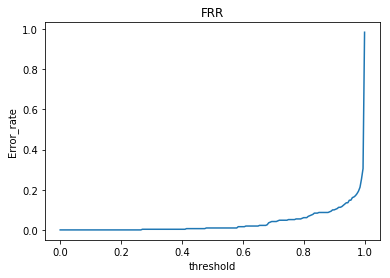

In [29]:
# importing the required module 
import matplotlib.pyplot as plt 

# x axis values 
# FRR 
# corresponding y axis values 
# t

# plotting the points 
plt.plot(t, FRR_face) 

# naming the x axis 
plt.xlabel('threshold') 
# naming the y axis 
plt.ylabel('Error_rate') 

# giving a title to my graph 
plt.title('FRR') 

# function to show the plot 
plt.show() 


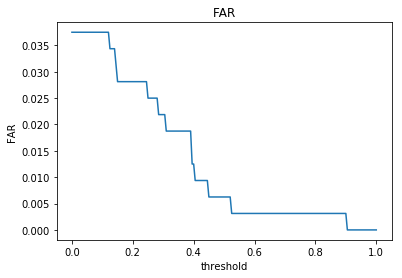

In [34]:
# plotting the points 
plt.plot(t, FAR_face) 

# naming the x axis 
plt.xlabel('threshold') 
# naming the y axis 
plt.ylabel('FAR') 

# giving a title to my graph 
plt.title('FAR') 

# function to show the plot 
plt.show() 

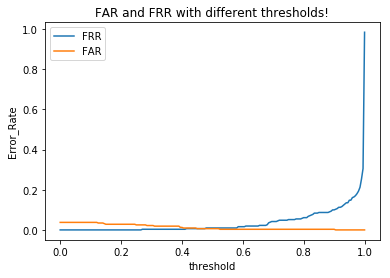

In [36]:
#plt.axis([0, 1, 0, 0.03])
# line 1 points 
# plotting the line 1 points 
plt.plot(t, FRR_face, label = "FRR") 

# line 2 points 
# plotting the line 2 points 
plt.plot(t, FAR_face, label = "FAR") 

# naming the x axis 
plt.xlabel('threshold') 
# naming the y axis 
plt.ylabel('Error_Rate') 
# giving a title to my graph 
plt.title('FAR and FRR with different thresholds!') 


# show a legend on the plot 
plt.legend() 

# function to show the plot 
plt.show() 

# Eye1 Verification

## X_train, X_test

In [0]:
#open files from your local file system
from google.colab import files

uploaded_eye1_train = files.upload()

for fn in uploaded_eye_train.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_eye_train[fn])))

In [0]:
eye1_X = []
for key, value in uploaded_eye1_train.items():
          img_path = key
          img = image.load_img(img_path, target_size=(128, 128))#loads as image in the PIL format
          x = image.img_to_array(img)#equal to cv2
          x = np.expand_dims(x, axis=0)#to respond to the input dimensions of the model
          x = preprocess_input(x)#normalizing pixel values to caffe style
          eye1_X.append(x)

In [43]:
eye1_X = np.array(eye1_X)
eye1_X = eye1_X.reshape(eye1_X.shape[0],128, 128, 3)
eye1_X.shape

(957, 128, 128, 3)

## Y_Train, Y_test

In [0]:
keys=[]
for key, value in uploaded_eye1_train.items():
  keys.append(key[1:3])
keys = [key.replace('_', '') for key in keys]
eye1_Y= np.array([int(i) for i in keys])

# train/test split

In [0]:
X_train_eye1, X_test_eye1, y_train_eye1, y_test_eye1 = train_test_split(eye1_X, eye1_Y, test_size=0.33, random_state=42)

## one-hot encode the labels to feed the keras model

In [0]:
Y_train_eye1 = convert_to_one_hot(y_train_eye1,32).T
Y_test_eye1 = convert_to_one_hot(y_test_eye1,32).T

## Model


### Creating the base model using transfer learning

In [48]:
img_height,img_width = 128,128
num_classes = 32
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [49]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model_eye1 = Model(inputs = base_model.input, outputs = predictions)

W0701 15:23:19.938106 140685096044416 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model_eye1.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

## Training the model

In [52]:
model_eye1.fit(X_train_eye1, Y_train_eye1, epochs = 50, batch_size = 32)

Epoch 1/50
641/641 [==============================] - 13s 21ms/step - loss: 3.7092 - acc: 0.1654
Epoch 2/50
641/641 [==============================] - 3s 5ms/step - loss: 1.5366 - acc: 0.6006
Epoch 3/50
641/641 [==============================] - 3s 5ms/step - loss: 0.7988 - acc: 0.8081
Epoch 4/50
641/641 [==============================] - 3s 5ms/step - loss: 0.4314 - acc: 0.9095
Epoch 5/50
641/641 [==============================] - 3s 5ms/step - loss: 0.2733 - acc: 0.9594
Epoch 6/50
641/641 [==============================] - 3s 5ms/step - loss: 0.1787 - acc: 0.9688
Epoch 7/50
641/641 [==============================] - 3s 5ms/step - loss: 0.1326 - acc: 0.9766
Epoch 8/50
641/641 [==============================] - 3s 5ms/step - loss: 0.1004 - acc: 0.9875
Epoch 9/50
641/641 [==============================] - 3s 5ms/step - loss: 0.0726 - acc: 0.9891
Epoch 10/50
641/641 [==============================] - 3s 5ms/step - loss: 0.0575 - acc: 0.9922
Epoch 11/50
641/641 [==========================

## Evaluating the model on the test set

In [53]:
preds = model_eye1.evaluate(X_test_eye1, Y_test_eye1)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

316/316 [==============================] - 3s 9ms/step
Loss = 0.057222424287207516
Test Accuracy = 0.990506329113924


In [55]:
len(y_test_eye1)

316

## False Rejection Rate

In [0]:
TP_eye1 = 0
tp_eye1=[]
fn_eye1=[]
predicts=[]
FN_eye1 = 0 #False Negative(False Rejection)/typeI error
FRR_eye1 = []
for T in threshold: 
  #for key, value in uploaded_eye_test.items():
  for i in range(0, 316):
    
            x = np.expand_dims(X_test_eye1[i], axis=0)#to respond to the input dimensions of the model
      
            label = y_test_eye1[i]
        
            p = model_eye1.predict(x)
            predicts.append(p)
          
            if np.amax(p)>=T and label == p.argmax(): # Top matched value's label is equal to the probe's label and the probabiliy surpasses the T
              TP_eye1+=1
              

            if np.amax(p)<T and  label == p.argmax(): # Top matched value's label is the same as the probe's class but this value is lower than the threshold set so, the genuine probe won't be allowed in the system and this is a false reject
              FN_eye1+=1

            #if np.amax(p) >=T and label != p.argmax(): # Top matched value's label is not equal to the label (wrong match) and this probability surpasses the T value so we get a False Acceptance error
            #  FP+=1
  FRR_eye1.append(FN_eye1/(FN_eye1+TP_eye1))
  
  tp_eye1.append(TP_eye1)
  fn_eye1.append(FN_eye1)
  
  TP_eye1=0
  FN_eye1=0

## False Acceptance Rate

In [0]:
#open files from your local file system
from google.colab import files

uploaded_imposter_eye1 = files.upload()

for fn in uploaded_imposter_eye1.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_imposter_eye1[fn])))

In [0]:
imposter_keys_eye1=[]
for key in uploaded_imposter_eye1.keys():
  imposter_keys_eye1.append(key[1:3])

In [0]:
TN_eye1 = 0
FP_eye1 = 0 #False Positive(False Acceptance)/typeII error
FAR_eye1 = []
for T in threshold:
  key_index = 0
  for key, value in uploaded_imposter_eye1.items():
          img_path = key
          img = image.load_img(img_path, target_size=(128, 128))#loads as image in the PIL format
          x = image.img_to_array(img)#equal to cv2
          x = np.expand_dims(x, axis=0)#to respond to the input dimensions of the model
          x = preprocess_input(x)#normalizing pixel values to caffe style
          label = int(imposter_keys_eye1[key_index])
          key_index+=1

          p = model_eye1.predict(x)
          if np.amax(p)>=T and label == p.argmax(): # An imposter pretending to be one of genuine probes, top matches and this probabbility surpasses the T value
            FP_eye1 +=1

          if np.amax(p)<T: # An imposter pretening to be a genuine probe, matches the highest but this probability does not surpass the T value
            TN_eye1 +=1

          if np.amax(p)>T and label != p.argmax():
            TN_eye1 +=1

          #if np.amax(p) >=T and label != p.argmax(): # Top matched value's label is not equal to the label (wrong match) and this probability surpasses the T value so we get a False Acceptance error
          #  FP+=1

          #L.append([p, label, (np.amax(p), p.argmax())])

  FAR_eye1.append(FP_eye1/(TN_eye1+FP_eye1))    
  FP_eye1=0
  TN_eye1=0      

## Plotting

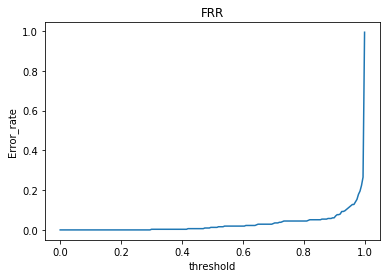

In [57]:
# importing the required module 
import matplotlib.pyplot as plt 

# x axis values 
# FRR 
# corresponding y axis values 
# t

# plotting the points 
plt.plot(t, FRR_eye1) 

# naming the x axis 
plt.xlabel('threshold') 
# naming the y axis 
plt.ylabel('Error_rate') 

# giving a title to my graph 
plt.title('FRR') 

# function to show the plot 
plt.show() 

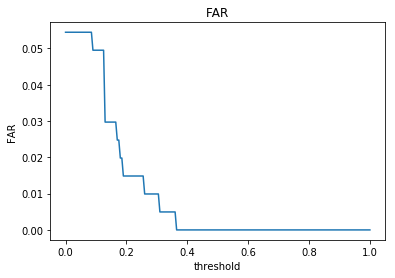

In [72]:
# plotting the points 
plt.plot(t, FAR_eye1) 

# naming the x axis 
plt.xlabel('threshold') 
# naming the y axis 
plt.ylabel('FAR') 

# giving a title to my graph 
plt.title('FAR') 

# function to show the plot 
plt.show()

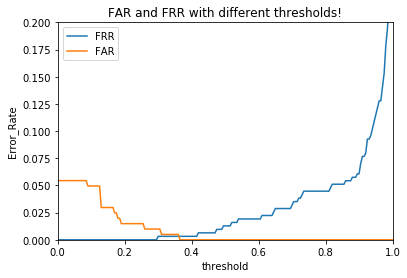

In [73]:
plt.axis([0, 1, -0, 0.2])
# line 1 points 
# plotting the line 1 points 
plt.plot(t, FRR_eye1, label = "FRR") 

# line 2 points 
# plotting the line 2 points 
plt.plot(t, FAR_eye1, label = "FAR") 

# naming the x axis 
plt.xlabel('threshold') 
# naming the y axis 
plt.ylabel('Error_Rate') 
# giving a title to my graph 
plt.title('FAR and FRR with different thresholds!') 


# show a legend on the plot 
plt.legend() 

# function to show the plot 
plt.show()

# Eye2 Verification 

In [0]:
#open files from your local file system
from google.colab import files

uploaded_eye2 = files.upload()

for fn in uploaded_eye2.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_eye2[fn])))

### Preparing data items and their labels to feed to the train_test_split function

In [0]:
Images_X = []
for key, value in uploaded_eye2.items():
          img_path = key
          img = image.load_img(img_path, target_size=(128, 128))#loads as image in the PIL format
          x = image.img_to_array(img)#equal to cv2
          x = np.expand_dims(x, axis=0)#to respond to the input dimensions of the model
          x = preprocess_input(x)#normalizing pixel values to caffe style
          Images_X.append(x)

In [79]:
Images_X = np.array(Images_X)
Images_X = Images_X.reshape(Images_X.shape[0],128, 128, 3)
Images_X.shape

(966, 128, 128, 3)

In [0]:
keys=[]
for key, value in uploaded_eye2.items():
  keys.append(key[1:3])
keys = [key.replace('_', '') for key in keys]
Images_Y = np.array([int(i) for i in keys])

### train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(Images_X, Images_Y, test_size=0.33, random_state=42)

### one hot encoding the labels to feed the keras model

In [0]:
Y_train = convert_to_one_hot(y_train,32).T
Y_test = convert_to_one_hot(y_test,32).T

# Model

In [83]:
img_height,img_width = 128,128
num_classes = 32
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [84]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model_eye2 = Model(inputs = base_model.input, outputs = predictions)

W0701 19:13:43.532840 140685096044416 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [0]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model_eye2.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
model_eye2.fit(X_train, Y_train, epochs = 50, batch_size = 32)

Epoch 1/50
647/647 [==============================] - 19s 29ms/step - loss: 3.7201 - acc: 0.1546
Epoch 2/50
647/647 [==============================] - 3s 5ms/step - loss: 1.5472 - acc: 0.5796
Epoch 3/50
647/647 [==============================] - 3s 5ms/step - loss: 0.7782 - acc: 0.7929
Epoch 4/50
647/647 [==============================] - 3s 5ms/step - loss: 0.4093 - acc: 0.9165
Epoch 5/50
647/647 [==============================] - 3s 5ms/step - loss: 0.2017 - acc: 0.9614
Epoch 6/50
647/647 [==============================] - 3s 5ms/step - loss: 0.1356 - acc: 0.9861
Epoch 7/50
647/647 [==============================] - 3s 5ms/step - loss: 0.0787 - acc: 0.9845
Epoch 8/50
647/647 [==============================] - 3s 5ms/step - loss: 0.0402 - acc: 0.9985
Epoch 9/50
647/647 [==============================] - 3s 5ms/step - loss: 0.0281 - acc: 1.0000
Epoch 10/50
647/647 [==============================] - 3s 5ms/step - loss: 0.0270 - acc: 0.9954
Epoch 11/50
647/647 [==========================

In [88]:
preds = model_eye2.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

319/319 [==============================] - 4s 12ms/step
Loss = 0.031516179424888664
Test Accuracy = 0.9937304075235109


In [89]:
len(X_test)

319

# Evaluation 

### False Rejection Rate

In [0]:
TP_eye2 = 0
FN_eye2 = 0 #False Negative(False Rejection)/typeI error
FRR_eye2 = []
for T in threshold: 
  #for key, value in uploaded_eye_test.items():
  for i in range(0, 319):
    
            x = np.expand_dims(X_test[i], axis=0)#to respond to the input dimensions of the model
      
            label = y_test[i]
        
            p = model_eye2.predict(x)
          
            if np.amax(p)>=T and label == p.argmax(): # Top matched value's label is equal to the probe's label and the probabiliy surpasses the T
              TP_eye2+=1

            if np.amax(p)<T and  label == p.argmax(): # Top matched value's label is the same as the probe's class but this value is lower than the threshold set so, the genuine probe won't be allowed in the system and this is a false reject
              FN_eye2+=1

            #if np.amax(p) >=T and label != p.argmax(): # Top matched value's label is not equal to the label (wrong match) and this probability surpasses the T value so we get a False Acceptance error
            #  FP+=1
  FRR_eye2.append(FN_eye2/(FN_eye2+TP_eye2))    
  TP_eye2=0
  FN_eye2=0

### False Acceptance Rate

In [0]:
#open files from your local file system
from google.colab import files

uploaded_imposter_eye2 = files.upload()

for fn in uploaded_imposter_eye2.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_imposter_eye2[fn])))

In [0]:
imposter_keys_eye2=[]
for key in uploaded_imposter_eye2.keys():
  imposter_keys_eye2.append(key[1:3])

In [0]:
TN_eye2 = 0
FP_eye2 = 0 #False Positive(False Acceptance)/typeII error
FAR_eye2=[]
#predicts = []
for T in threshold:
  key_index = 0
  for key, value in uploaded_imposter_eye2.items():
            img_path = key
            img = image.load_img(img_path, target_size=(128, 128))#loads as image in the PIL format
            x = image.img_to_array(img)#equal to cv2
            x = np.expand_dims(x, axis=0)#to respond to the input dimensions of the model
            x = preprocess_input(x)#normalizing pixel values to caffe style
            label = int(imposter_keys_eye2[key_index])
            key_index+=1

            p = model_eye2.predict(x)
            #predicts.append(p)
            if np.amax(p)>=T and label == p.argmax(): # An imposter pretending to be one of genuine probes, top matches and this probabbility surpasses the T value
              FP_eye2+=1

            if np.amax(p)<T: # An imposter pretening to be a genuine probe, matches the highest but this probability does not surpass the T value
              TN_eye2+=1

            if np.amax(p)>T and label != p.argmax():
              TN_eye2+=1

            #if np.amax(p) >=T and label != p.argmax(): # Top matched value's label is not equal to the label (wrong match) and this probability surpasses the T value so we get a False Acceptance error
            #  FP+=1

            #L.append([p, label, (np.amax(p), p.argmax())])

  FAR_eye2.append(FP_eye2/(TN_eye2+FP_eye2))    
  FP_eye2=0
  TN_eye2=0   

# Plots

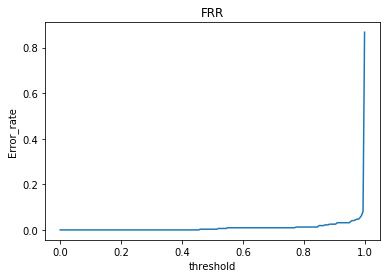

In [91]:
# importing the required module 
import matplotlib.pyplot as plt 

# x axis values 
# FRR 
# corresponding y axis values 
# t

# plotting the points 
plt.plot(t, FRR_eye2) 

# naming the x axis 
plt.xlabel('threshold') 
# naming the y axis 
plt.ylabel('Error_rate') 

# giving a title to my graph 
plt.title('FRR') 

# function to show the plot 
plt.show() 

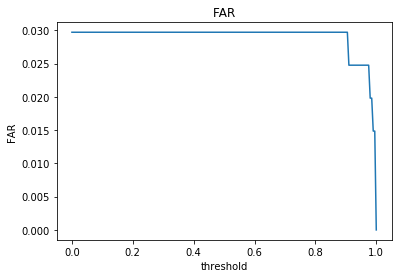

In [111]:
# plotting the points 
plt.plot(t, FAR_eye2) 

# naming the x axis 
plt.xlabel('threshold') 
# naming the y axis 
plt.ylabel('FAR') 

# giving a title to my graph 
plt.title('FAR') 

# functionto show the plot 
plt.show()

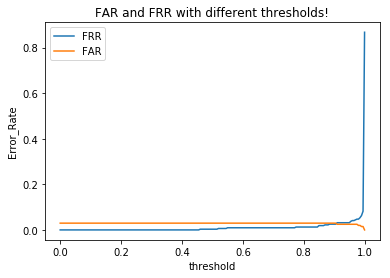

In [112]:
#plt.axis([0, 1, -0, 0.150])
# line 1 points 
# plotting the line 1 points 
plt.plot(t, FRR_eye2, label = "FRR") 

# line 2 points 
# plotting the line 2 points 
plt.plot(t, FAR_eye2, label = "FAR") 

# naming the x axis 
plt.xlabel('threshold') 
# naming the y axis 
plt.ylabel('Error_Rate') 
# giving a title to my graph 
plt.title('FAR and FRR with different thresholds!') 


# show a legend on the plot 
plt.legend() 

# function to show the plot 
plt.show()

# Multibiometrics


### Experimental section - to be completed



1.   Face+Eye1
2.   Face+Eye2
3.   Face+Eye1+Eye2
4.   Eye1+Eye2



### Face+Eye1

In [0]:
face_test_keys=face_test_keys[0:10]

In [0]:
zip(face_test_keys, eye_test_keys)

In [0]:
TP = 0
FN = 0 #False Negative(False Rejection)/typeI error
FRR = []
for T in threshold: 
  for face_key, eye_key in zip(face_test_keys, eye_test_keys):
            face_path = face_key
            img = image.load_img(face_path, target_size=(128, 128))#loads as image in the PIL format
            x = image.img_to_array(img)#equal to cv2
            x = np.expand_dims(x, axis=0)#to respond to the input dimensions of the model
            x = preprocess_input(x)#normalizing pixel values to caffe style
            label = int(face_key[1])
            p_face = model.predict(x)
            
            eye_path = eye_key
            img = image.load_img(eye_path, target_size=(128, 128))#loads as image in the PIL format
            x = image.img_to_array(img)#equal to cv2
            x = np.expand_dims(x, axis=0)#to respond to the input dimensions of the model
            x = preprocess_input(x)#normalizing pixel values to caffe style
            #label_eye = int(eye_key[1])

            p_eye = model_eye.predict(x)
            
            
            p = np.array([x + y for x, y in zip(p_face, p_eye)]) # summing the list of probabilities predicted by two modals
            
            if np.amax(p)>=T and label == p.argmax(): # Top matched value's label is equal to the probe's label and the probabiliy surpasses the T
              TP+=1

            if np.amax(p)<T and  label == p.argmax(): # Top matched value's label is the same as the probe's class but this value is lower than the threshold set so, the genuine probe won't be allowed in the system and this is a false reject
              FN+=1


            #if np.amax(p) >=T and label != p.argmax(): # Top matched value's label is not equal to the label (wrong match) and this probability surpasses the T value so we get a False Acceptance error
            #  FP+=1
  FRR.append(FN/(FN+TP))    
  TP=0
  FN=0

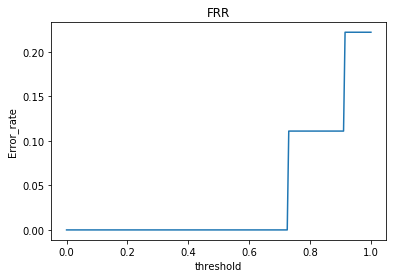

In [0]:
# importing the required module 
import matplotlib.pyplot as plt 

# x axis values 
# FRR 
# corresponding y axis values 
# t

# plotting the points 
plt.plot(t, FRR) 

# naming the x axis 
plt.xlabel('threshold') 
# naming the y axis 
plt.ylabel('Error_rate') 

# giving a title to my graph 
plt.title('FRR') 

# function to show the plot 
plt.show() 

In [0]:
# face_imposter_keys
# eye_imposter_keys

In [0]:
TP = 0
FN = 0 #False Negative(False Rejection)/typeI error
FAR = []
for T in threshold: 
  for face_key, eye_key in zip(face_imposter_keys, eye_imposter_keys):
            face_path = face_key
            img = image.load_img(face_path, target_size=(128, 128))#loads as image in the PIL format
            x = image.img_to_array(img)#equal to cv2
            x = np.expand_dims(x, axis=0)#to respond to the input dimensions of the model
            x = preprocess_input(x)#normalizing pixel values to caffe style
            label = int(face_key[1])
            p_face = model.predict(x)
            
            eye_path = eye_key
            img = image.load_img(eye_path, target_size=(128, 128))#loads as image in the PIL format
            x = image.img_to_array(img)#equal to cv2
            x = np.expand_dims(x, axis=0)#to respond to the input dimensions of the model
            x = preprocess_input(x)#normalizing pixel values to caffe style
            #label_eye = int(eye_key[1])

            p_eye = model_eye.predict(x)
            
            
            p = np.array([x + y for x, y in zip(p_face, p_eye)]) # summing the list of probabilities predicted by two modals
            
            if np.amax(p)>=T and label == p.argmax(): # Top matched value's label is equal to the probe's label and the probabiliy surpasses the T
              TP+=1

            if np.amax(p)<T and  label == p.argmax(): # Top matched value's label is the same as the probe's class but this value is lower than the threshold set so, the genuine probe won't be allowed in the system and this is a false reject
              FN+=1


            #if np.amax(p) >=T and label != p.argmax(): # Top matched value's label is not equal to the label (wrong match) and this probability surpasses the T value so we get a False Acceptance error
            #  FP+=1
  FRR.append(FN/(FN+TP))    
  TP=0
  FN=0